# Lecture 20: Parallelism



## Working with Images

[OpenCV](https://github.com/opencv/opencv-python) is an expanse package for manpulating images and video. You can easily install it with pip:

`pip install opencv-python`

In [17]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
!rm *.png

In [19]:
!ls

Lecture.20.ipynb              my_functions.py
convert_jpeg_to_png.py        university-center-horses2.jpg


In [20]:
an_image = cv2.imread("university-center-horses2.jpg")

In [21]:
an_image

array([[[155, 128,  84],
        [155, 128,  84],
        [155, 128,  84],
        ...,
        [155, 130,  90],
        [155, 130,  90],
        [155, 130,  90]],

       [[155, 128,  84],
        [155, 128,  84],
        [155, 128,  84],
        ...,
        [156, 131,  91],
        [156, 131,  91],
        [156, 131,  91]],

       [[155, 128,  84],
        [155, 128,  84],
        [155, 128,  84],
        ...,
        [156, 131,  91],
        [156, 131,  91],
        [156, 131,  91]],

       ...,

       [[  8,  37,  51],
        [ 55,  62, 125],
        [ 89,  80, 184],
        ...,
        [ 54,  74,  99],
        [  0,   3,  33],
        [ 10,  10,  50]],

       [[ 13,  40,  60],
        [ 65,  61, 156],
        [112, 102, 208],
        ...,
        [ 92, 116, 128],
        [ 14,  25,  45],
        [ 12,  16,  45]],

       [[ 39,  46, 101],
        [ 86,  75, 171],
        [124, 108, 219],
        ...,
        [ 82, 106, 118],
        [ 25,  38,  54],
        [  0,   0,  20]]

In [22]:
an_image.shape

(958, 1440, 3)

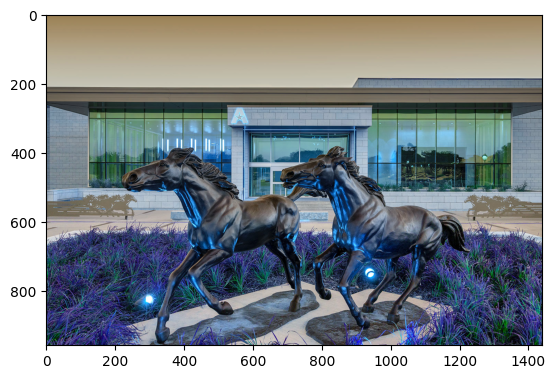

In [23]:
plt.imshow(an_image)

You can easily change file format:

In [24]:
cv2.imwrite('an_image.png', an_image)

True

Note the `png` file is much larger because it's an uncompressed format. 

In [25]:
!ls -lh

total 6384
-rw-r--r--@ 1 afarbin  staff   565K Nov 29 11:11 Lecture.20.ipynb
-rw-r--r--  1 afarbin  staff   2.2M Nov 29 11:12 an_image.png
-rw-r--r--@ 1 afarbin  staff   439B Nov 29 11:08 convert_jpeg_to_png.py
-rw-r--r--@ 1 afarbin  staff   1.5K Nov 29 11:08 my_functions.py
-rw-r--r--@ 1 afarbin  staff   398K Nov 29 11:08 university-center-horses2.jpg


We can write write a convert function 

In [26]:
def convert_jpeg_to_png(in_filename,out_filename=None):
    if out_filename is None:
        out_filename=in_filename.split(".")[0]+".png"
    
    an_image = cv2.imread(in_filename)
    cv2.imwrite(out_filename, an_image)

In [27]:
convert_jpeg_to_png("university-center-horses2.jpg")

In [28]:
!ls -lh

total 10816
-rw-r--r--@ 1 afarbin  staff   565K Nov 29 11:11 Lecture.20.ipynb
-rw-r--r--@ 1 afarbin  staff   2.2M Nov 29 11:12 an_image.png
-rw-r--r--@ 1 afarbin  staff   439B Nov 29 11:08 convert_jpeg_to_png.py
-rw-r--r--@ 1 afarbin  staff   1.5K Nov 29 11:08 my_functions.py
-rw-r--r--@ 1 afarbin  staff   398K Nov 29 11:08 university-center-horses2.jpg
-rw-r--r--@ 1 afarbin  staff   2.2M Nov 29 11:12 university-center-horses2.png


And note that it takes some time to do the conversion:

In [29]:
%time convert_jpeg_to_png("university-center-horses2.jpg")

CPU times: user 58.2 ms, sys: 7.37 ms, total: 65.5 ms
Wall time: 64.8 ms


Therefore if we had to convert 1000s of images, it would take some time.

## Parallelism 

(Partially drawn from [wikipedia](https://en.wikipedia.org/wiki/Parallel_computing))

*Parallel* computing is a type of computation where many calculations or the execution of processes are carried out simultaneously. So far all of the python code we have written has been a *serial* stream of instructions, one executed after another. There has been some parallelism provided by some of the underlying libraries, the operating system, and hardware.

In order to parallelize a problem it has to be broken into independent parts so that separate processing elements of the CPU can simultaneously work with the others. The processing elements can be diverse and include resources such as a single computer with multiple processors, several networked computers, specialized hardware, or any combination of the above.

Some problems are *trivially parallelizable*. For example, since no image depends on any other image, converting the format of 1000s images requires just running the same computation on several files at the same time. Other problems may exhibit complex relationships between parallelized parts that require careful orchestration of the parts to properly perform the computation and/or gain meaningful benefit from parallelization. We are not going to dive into this rich topic at this time. Instead, let's start with what we can do easily in python.

As you are probably aware, most modern CPUs consist of multiple cores, each of which can execute at least one instruction simultaneously. Note that since different instructions utilize different parts of each core, many modern cores can simultaneously execute multiple instructions. 

So the simplest means for us to use parallelism to speed up tasks is to simultaneously utilize the multiple cores in modern CPUs. 



### Multi-threading versus Multi-processing

As explained before, when you run a program in a modern operating system, the OS creates a new process associated with that program. If you have multiple processes running, the OS apportions CPU clock cycles to each running process. If there are multiple cores, then all cores can be simultaneously occupied by different process. Therefore a trival means of parallelizing an operation like converting a file formats could be achieved by running multiple instances of the same program on different files. For example we can write the convert function above into a python file, and modify it such the input and output filenames can be provided as command line options.

Lets take a look: [convert_jpeg_to_png.py](convert_jpeg_to_png.py).


Note that these processes do not communicate with each other. Eventhough they share the same resources (e.g. CPU, memory, and disk) the operating system keeps them completely separated. There are methods of communicating between processes using the file input/output machinery of UNIX, using *streams*, or by allocating *shared memory* that is accessible by multiple processes. Setting up multiple processes to communicate this way requires a program to orchestrate everything.

We just described *multi-processing*. The OS also allows processes to break down their code into threads that share memory and other resources. While this *Multi-threading* can be used to parallelize programs to speed them up, it also can serve as a good means of organizing a computation even when there is only one core. Unfortunately, careful attention has to be make to sure computations are run in the proper order and memory is accessed appropriately. Because of this, while multi-treading is supported in python, python is limited to running a single thread at a time and it is therefore difficult to obtain significant speedups with multi-threading with Python. This issue is referred to as the *global interpreter lock* or *GIL*. 



### Multi-processing in python

Eventhough multi-threading isn't very motivated in python, the interface it provides is rather nice, so while python provides various methods of multi-processing, the most common multi-processing method is to use the multi-threading interface! 

Lets look at the [documentation on multi-processing](https://docs.python.org/3/library/multiprocessing.html).

Unfortunately, there are some additional complications with multi-processing while running in Jupyter notebooks. As a result, it is best to write functions you want to using with multi-processing in their own python modules.

Lets take a look at the functions: [my_functions](my_functions.py).

Simplest way to use multiprocessing is to create a pool and use map:

In [30]:
from multiprocessing import Pool
import my_functions

# Reload the module, in case we modified it
import importlib
importlib.reload(my_functions)

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(my_functions.square, [1, 2, 3]))
        

[1, 4, 9]


There is the additional problem that Juptyer will not capture the any print output of your functions. Instead the output will come out where you ran your function. For example, consier the `printer` function.

In [31]:
from multiprocessing import Process

print('Starting demo...')
p = Process(target=my_functions.printer, args=('hello demo',))
p.start()

Starting demo...


Here is another example that demonstates running several processes:

In [32]:
proc_list = []
for values in [('immediate', 0), ('delayed', 10), ('eternity', 20)]:
    p = Process(target=my_functions.printer, args=values)
    proc_list.append(p)
    p.start()  # start execution of printer

print('Waiting for proccesses to finish...')
    
[p.join() for p in proc_list]

print('After processes...')

Waiting for proccesses to finish...
Pid: 67912, PPid: 67843, Value: immediate
Pid: 67911, PPid: 67843, Value: hello demo
Pid: 67913, PPid: 67843, Value: delayed
Pid: 67914, PPid: 67843, Value: eternity
After processes...


Now lets try the jpeg to png conversion:

In [33]:
!rm *.png

In [34]:
import convert_jpeg_to_png

for i in range(100):
    p = Process(target=convert_jpeg_to_png.convert_jpeg_to_png, 
                args=("university-center-horses2.jpg",str(i)+".png",))
    print("Starting Job:",i)
    p.start()
    

Starting Job: 0
Starting Job: 1
Starting Job: 2
Starting Job: 3
Starting Job: 4
Starting Job: 5
Starting Job: 6
Starting Job: 7
Starting Job: 8
Starting Job: 9
Starting Job: 10
Starting Job: 11
Starting Job: 12
Starting Job: 13
Starting Job: 14
Starting Job: 15
Starting Job: 16
Starting Job: 17
Starting Job: 18
Starting Job: 19
Starting Job: 20
Starting Job: 21
Starting Job: 22
Starting Job: 23
Starting Job: 24
Starting Job: 25
Starting Job: 26
Starting Job: 27
Starting Job: 28
Starting Job: 29
Starting Job: 30
Starting Job: 31
Starting Job: 32
Starting Job: 33
Starting Job: 34
Starting Job: 35
Starting Job: 36
Starting Job: 37
Starting Job: 38
Starting Job: 39
Starting Job: 40
Starting Job: 41
Starting Job: 42
Starting Job: 43
Starting Job: 44
Starting Job: 45
Starting Job: 46
Starting Job: 47
Starting Job: 48
Starting Job: 49
Starting Job: 50
Starting Job: 51
Starting Job: 52
Starting Job: 53
Starting Job: 54
Starting Job: 55
Starting Job: 56
Starting Job: 57
Starting Job: 58
Startin

In [35]:
!ls

Lecture.20.ipynb              my_functions.py
convert_jpeg_to_png.py        university-center-horses2.jpg


In [36]:
!rm *.png

zsh:1: no matches found: *.png


Note that in the conversion example we didn't wait for the processes to complete. Here's an example where we do:

In [37]:
import convert_jpeg_to_png

process_list = list()

for i in range(100):
    p = Process(target=convert_jpeg_to_png.convert_jpeg_to_png, 
                args=("university-center-horses2.jpg",str(i)+".png",))
    print("Starting Job:",i)
    p.start()
    process_list.append(p)
    
    
for p in process_list:
    p.join()

Starting Job: 0
Starting Job: 1
Starting Job: 2
Starting Job: 3
Starting Job: 4
Starting Job: 5
Starting Job: 6
Starting Job: 7
Starting Job: 8
Starting Job: 9
Starting Job: 10
Starting Job: 11
Starting Job: 12
Starting Job: 13
Starting Job: 14
Starting Job: 15
Starting Job: 16
Starting Job: 17
Starting Job: 18
Starting Job: 19
Starting Job: 20
Starting Job: 21
Starting Job: 22
Starting Job: 23
Starting Job: 24
Starting Job: 25
Starting Job: 26
Starting Job: 27
Starting Job: 28
Starting Job: 29
Starting Job: 30
Starting Job: 31
Starting Job: 32
Starting Job: 33
Starting Job: 34
Starting Job: 35
Starting Job: 36
Starting Job: 37
Starting Job: 38
Starting Job: 39
Starting Job: 40
Starting Job: 41
Starting Job: 42
Starting Job: 43
Starting Job: 44
Starting Job: 45
Starting Job: 46
Starting Job: 47
Starting Job: 48
Starting Job: 49
Starting Job: 50
Starting Job: 51
Starting Job: 52
Starting Job: 53
Starting Job: 54
Starting Job: 55
Starting Job: 56
Starting Job: 57
Starting Job: 58
Startin

In [38]:
!rm *.png

## Inter-process Communication

In the previous examples, we spawned a new process for each file that we converted, so for 100 files, we spawned 100 processes. But the operating system can only simultaneously run as many processes as there are cores on the CPU. Therefore, only a handful of prcesses ever ran at the same time and we wasted system resources starting and holding in memory a lot of processes. 

Instead we could start just a handful of processes, and use inter-process communication to tell each processes to convert multiple files.

First lets set things up so that the processes get the input/output filenames from a queue:

In [39]:
from multiprocessing import Process, Queue
import my_functions

# Reload the module, in case we modified it
import imp
imp.reload(my_functions)

q = Queue()
p = Process(target=my_functions.convert, args=(q,))
p.start()

q.put(("university-center-horses2.jpg","test.png"))


/var/folders/zy/0rgyywr10tq2p0l5lkdf14v80000gq/T/ipykernel_67843/3577756955.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [40]:
!ls

Lecture.20.ipynb              my_functions.py
convert_jpeg_to_png.py        university-center-horses2.jpg


In [41]:
!rm *.png

zsh:1: no matches found: *.png


Now that we know how to communicate between processes, lets setup a method of queuing up input/output filenames to be processes by just a handful of processes:

In [42]:
import my_functions

# Reload the module, in case we modified it
import imp
imp.reload(my_functions)

n_processes = 4

q = Queue()

for i in range(n_processes):
    p = Process(target=my_functions.convert_many, args=(q,))
    p.start()

for j in range(1000):
    q.put(("university-center-horses2.jpg",str(j)+".png"))

for i in range(n_processes):
    q.put(("DONE",""))
    


In [43]:
!ls

Lecture.20.ipynb              my_functions.py
convert_jpeg_to_png.py        university-center-horses2.jpg


In [44]:
!rm *.png

zsh:1: no matches found: *.png


Note that in the example above we used one queue shared between all of the processes. Queues are useful for one directional communication. You may do multi-directional communication, shared by multiple processes, by creating an two queues: one for communicating from the parent process to the children processes, and another for the reverse. Altnernatively, you could use pipe for bi-directional communication. But here you will run into issues if multiple processes attempt to simulaneously write to the same pipe. You may avoid this issue by setting up separate pipe for communication between the parent and each child process.

## Loading Images into Memory Example
As an example, lets address another problem. Lets say you want to speed up loading many images into memory. Loading one image takes some time:

In [45]:
%time image=cv2.imread("university-center-horses2.jpg")

CPU times: user 19.5 ms, sys: 3.56 ms, total: 23 ms
Wall time: 42.4 ms


In [46]:
import my_functions

# Reload the module, in case we modified it
import imp
imp.reload(my_functions)

n_processes = 4
n_images = 100

in_q = Queue()
out_q = Queue()

for i in range(n_processes):
    p = Process(target=my_functions.load_many, args=(in_q,out_q,))
    p.start()

for j in range(100):
    in_q.put("university-center-horses2.jpg")
    
for i in range(n_processes):
    in_q.put(("DONE"))
    
for j in range(100):
    image=out_q.get()
    print("Got Image:",j)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/synchronize.py", line 110, in __setstate__
    self._semlock = _multiprocessing.SemLock._rebuild(*state)
FileNotFoundError: [Errno 2] No such file or directory


Got Image: 0
Got Image: 1
Got Image: 2
Got Image: 3
Got Image: 4
Got Image: 5
Got Image: 6
Got Image: 7
Got Image: 8
Got Image: 9
Got Image: 10
Got Image: 11
Got Image: 12
Got Image: 13
Got Image: 14
Got Image: 15
Got Image: 16
Got Image: 17
Got Image: 18
Got Image: 19
Got Image: 20
Got Image: 21
Got Image: 22
Got Image: 23
Got Image: 24
Got Image: 25
Got Image: 26
Got Image: 27
Got Image: 28
Got Image: 29
Got Image: 30
Got Image: 31
Got Image: 32
Got Image: 33
Got Image: 34
Got Image: 35
Got Image: 36
Got Image: 37
Got Image: 38
Got Image: 39
Got Image: 40
Got Image: 41
Got Image: 42
Got Image: 43
Got Image: 44
Got Image: 45
Got Image: 46
Got Image: 47
Got Image: 48
Got Image: 49
Got Image: 50
Got Image: 51
Got Image: 52
Got Image: 53
Got Image: 54
Got Image: 55
Got Image: 56
Got Image: 57
Got Image: 58
Got Image: 59
Got Image: 60
Got Image: 61
Got Image: 62
Got Image: 63
Got Image: 64
Got Image: 65
Got Image: 66
Got Image: 67
Got Image: 68
Got Image: 69
Got Image: 70
Got Image: 71
Go

There is one final issue to consider here. Inter-process communication using queues works by sending data between processes. Therefore it effectively copies the data. If the data you are exchange is large, you not only waste a lot of memory by keeping multiple copies, you waste time making the copy.

## Example with Shared Memory

The solution to this issue is to establish shared memory between processes an instead communicate the location of the data. This technique uses *shared memory*. See [shared memory documentation](https://docs.python.org/3/library/multiprocessing.shared_memory.html) for details. 

Lets run the example from previous section, timing how long it takes.

In [47]:
from multiprocessing import Process, Queue
import my_functions
import time

# Reload the module, in case we modified it
import imp
imp.reload(my_functions)

start_time = time.time()
n_processes = 4
n_images = 1000

in_q = Queue()
out_q = Queue()

for i in range(n_processes):
    p = Process(target=my_functions.load_many, args=(in_q,out_q,))
    p.start()

for j in range(n_images):
    in_q.put("university-center-horses2.jpg")
    
for i in range(n_processes):
    in_q.put(("DONE"))

print("Got Image:")
for j in range(n_images):
    image=out_q.get()
    print(",",j,end="")

print()
print("Total time:", time.time()-start_time)

Got Image:
, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

Note the total time.

Now lets do the same thing using shared memory in order to avoid having to take time to make addition copies of the data.

Using shared memory takes a bit more effort. We'll have to actually allocate memory and specify that we will share it. Additional complications arrise because we want to use numpy arrays. Here's an example of what needs to be done.

First, lets figure out how much memory we'll need by loading and image in remembering the size and type of the data we get back:

In [48]:
import cv2

an_image = cv2.imread("university-center-horses2.jpg")

image_shape = an_image.shape
image_dtype = an_image.dtype

print(image_shape)
print(image_dtype)

(958, 1440, 3)
uint8


Next lets create a shared memory block, and note the unique name it gets so we let our processes access this memory:

In [49]:
from multiprocessing import shared_memory
from multiprocessing import Process, Queue

import numpy as np

n_images = 1000

# Create a dummy tensor of correct size
# Not necessary, but makes it a bit easier. 
# Might want to avoid this step to save memory.
images_0 = np.zeros((n_images,)+image_shape, dtype=image_dtype)

# Allocate shared memory block of appropriate size
shm = shared_memory.SharedMemory(create=True, size=images_0.nbytes)

# Wrap that memory in a tensor so we can access it easily
images = np.ndarray(images_0.shape, dtype=images_0.dtype, buffer=shm.buf)

# Set the values all to the original tensor (of all zeros), for safety.
images[:] = images_0[:]

# Get the shared memory name for use later
print(shm.name)

psm_f7fed61b


In [50]:
import my_functions

# Reload the module, in case we modified it
import imp
imp.reload(my_functions)

start_time = time.time()

n_processes = 4
n_images = 1000

in_q = Queue()
out_q = Queue()

for i in range(n_processes):
    # Note additional args here so we can let the process know:
    # 1. The share memory name
    # 2. How to properly create a tensor
    p = Process(target=my_functions.load_many_shm, 
                args=(in_q,out_q,shm.name,images.shape,images.dtype,))
    p.start()

for j in range(n_images):
    in_q.put(("university-center-horses2.jpg",j))
    
for i in range(n_processes):
    in_q.put(("DONE",0))

print("Got Image:")
for j in range(n_images):
    i=out_q.get()
    print(",",i,end="")
    
print()
time_taken=time.time()-start_time
print("Total time:", time_taken)

Got Image:
, 1, 3, 2, 0, 6, 5, 4, 7, 9, 8, 10, 11, 12, 13, 14, 15, 17, 16, 18, 19, 20, 21, 22, 23, 25, 24, 26, 27, 29, 30, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 76, 78, 79, 81, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 92, 94, 95, 97, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 118, 120, 121, 123, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 170, 172, 173, 175, 174, 176, 177, 178, 179, 180, 181, 183, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

dex: 392
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 396
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 401
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 405
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 409
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 413
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 417
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 421
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 425
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 429
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 434
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 437
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 441
Reading

, Index: 879
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 883
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 887
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 890
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 895
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 899
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 902
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 907
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 912
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 916
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 920
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 924
Reading: Pid: 68163, PPid: 67843, File: university-center-horses2.jpg, Index: 928
Rea

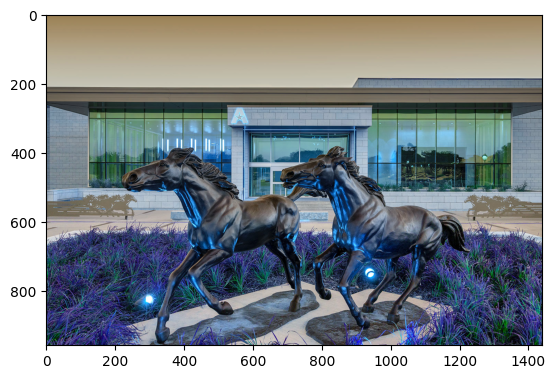

In [51]:
plt.imshow(images[10])

In [52]:
time_taken

5.573467969894409